## Turtlebot Block

We represent the **turtlebot block** as a dynamical system. The plant state vector $\mathbf{x}$ and input vector $\mathbf{u}$ are given by

$$
\mathbf{x} =
\begin{bmatrix}
x \\ 
y \\
\theta
\end{bmatrix},
\qquad  
\mathbf{u} =
\begin{bmatrix}
v \\ 
\omega
\end{bmatrix}.
$$

where  
- $x$ is the horizontal component of position,  
- $y$ is the vertical component of position,  
- $\theta$ is the angular displacement of the turtlebot heading w.r.t. the $+x$ axis (positive counterclockwise).  

and  
- $v$ is the commanded linear velocity,  
- $\omega$ is the commanded angular velocity.  

The turtlebot follows the standard unicycle kinematic model, so the dynamics are

$$
\dot{\mathbf{x}} = f(\mathbf{x}, \mathbf{u}) =
\begin{bmatrix}
v \cos\theta \\ 
v \sin\theta \\
\omega
\end{bmatrix}.
$$

We define the output function as the identity map, i.e.,

$$
\mathbf{y} = h(\mathbf{x}) = \mathbf{x}.
$$

Thus, the dynamical system is

$$
\dot{\mathbf{x}} = f(\mathbf{x}, \mathbf{u}) =
\begin{bmatrix}
v \cos\theta \\ 
v \sin\theta \\
\omega
\end{bmatrix},
\qquad
\mathbf{y} = h(\mathbf{x}) = \mathbf{x}.
$$

In [1]:
import numpy as np
from numpy.typing import NDArray
import pykal
from pykal.block_dynamical_system import BlockDynamicalSystem as BlockDS 

def turtlebot_dynamics(xk:NDArray, uk:NDArray) -> NDArray:
    x,y,th = float(xk[0]),float(xk[1]),float(xk[2])
    v,w = float(uk[0]), float(uk[1])

    xdot, ydot, thdot = v * np.cos(th), v * np.sin(th), w
    xkdot = np.atleast_2d([xdot,ydot,thdot])

    return xkdot.T


# if h is not initialized, it defaults to the identity map
turtlebot_block = BlockDS(f = turtlebot_dynamics, sys_type="cti") 
turtlebot_block.__dict__

{'_X': [],
 '_Y': [],
 '_f': <function __main__.turtlebot_dynamics(xk: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]], uk: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]]) -> numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]]>,
 '_h': <function pykal.block_dynamical_system.BlockDynamicalSystem.__init__.<locals>.identity_map(xk: numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]]) -> numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]]>,
 '_Q': None,
 '_R': None,
 '_sys_type': 'cti'}

In [ ]:
from pykal.compute import Simulation

x0 = [0,0,0] # at origin, facing +x direction
uk = [0,0] # no input
X,Y = Simulation.of_dynamical_system_block(block=turtlebot_block,x0=x0,t_span=(0,40),dt=0.1,arg_dict={"uk":uk})

In [ ]:
import pandas as pd
Ydf = pd.DataFrame(Y, columns=["x", "y", "theta"])

<Axes: title={'center': '2D Trajectory'}, xlabel='x'>

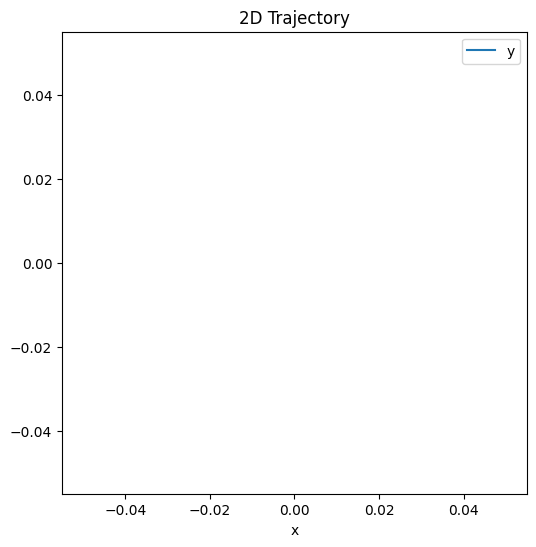

In [4]:
Ydf.plot(x="x", y="y", kind="line", figsize=(6, 6), title="2D Trajectory")

## Signal Block

In [5]:
def forward_v(magnitude_v: float = 0.25): # m/s (max for turtlebot4)
    return np.array([[magnitude_v], [0]])


def backward_v(magnitude_v: float = 0.25):
    return np.array([[-magnitude_v], [0]])


def ccw_w(magnitude_w: float = 0.5): # rad/s (max for turtlebot4)
    return np.array([[0], [magnitude_w]])

def cw_w(magnitude_w: float = 0.5):
    return np.array([[0],[-magnitude_w]])

def no_vw():
    return np.array([[0],[0]])

def move_forward(tk: float, t_start: float, t_end: float, magnitude_v: float = 1) -> NDArray:
    if t_start <= tk < t_end:
        return forward_v(magnitude_v)

def circle_cw(tk: float, t_start: float, t_end: float, magnitude_v: float = 1, magnitude_w: float = 1) -> NDArray:
    if t_start <= tk < t_end:
        return forward_v(magnitude_v) + cw_w(magnitude_w)

def circle_ccw(tk: float, t_start: float, t_end: float, magnitude_v: float = 1, magnitude_w: float = 1) -> NDArray:
    if t_start <= tk < t_end:
        return forward_v(magnitude_v) + ccw_w(magnitude_w)

In [6]:
def straight_loop_straight(tk: float) -> NDArray:
    return next((
        movement for movement in [
            move_forward(tk,0, 2,magnitude_v=0.25),
            circle_ccw(tk,2, 10,magnitude_v=0.25,magnitude_w=0.5), 
            move_forward(tk,10, 15,magnitude_v=0.25), 
            circle_cw(tk,15, 25,magnitude_v=0.25,magnitude_w=0.5),
            move_forward(tk,25, 35,magnitude_v=0.25),
            no_vw()
        ] if movement is not None
    ), None)

In [7]:
# if f is not initialized, it defaults to the zero dynamics
signal_block = DSBlock(h=straight_loop_straight) 
signal_block.__dict__

{'_X': [],
 '_Y': [],
 '_f': <function pykal_core.blocks.DSBlock.__init__.<locals>.zero_dynamics(xk: 'NDArray') -> 'NDArray'>,
 '_h': <function __main__.straight_loop_straight(tk: float) -> numpy.ndarray[tuple[typing.Any, ...], numpy.dtype[~_ScalarT]]>,
 '_Q': None,
 '_R': None,
 '_sys_type': None}

In [8]:
def system_wrapper_initialize():
    # initialize state history    
    turtlebot_x0 = [0,0]
    turtlebot_block.X.append(turtlebot_x0)        

    def system_wrapper(tk,input_arg_dict): 
        # use last state as input
        xk_prev = turtlebot_block.X[-1]
        # advance the system one time step forward
        xk,yk = Simulation.of_dynamical_system_block(block = turtlebot_block,
                                            x0=xk_prev,
                                            tk=tk,
                                            dt=0.1,
                                            arg_dict=input_arg_dict)
        turtlebot_block.X.append(xk)
        return {"/y_out":yk}

    return system_wrapper


In [9]:
def system_wrapper(tk): 
    # advance the system one time step forward
    uk = Simulation.of_dynamical_system_block(block = signal_block,tk=tk,dt=0.1)

    return {"/uk":uk}


In [10]:
t_span = np.arange(0,40,0.1) # time of simulation
xk = [0,0,0] # at origin, facing +x direction
for tk in t_span:
    # kinematic model input
    uk = Simulation.of_dynamical_system_block(block = signal_block,
                                              tk=tk,dt=0.1)
    # turtlebot dynamics
    xk,yk = Simulation.of_dynamical_system_block(block = turtlebot_block,
                                                 x0=xk,tk=tk,
                                                 dt=0.1,
                                                 arg_dict={"uk":uk})
    # turtlebot pose
    turtlebot_block.Y.append(yk)


In [11]:
def cmd_vel_py2ros():
    pass
def loop_de_loop():
    pass
from geometry_msgs.msg import Twist

In [12]:
from pykal_core.blocks import ROSBlock

node = ROSBlock(
    node_name="loop-de-loop trajectory",
    system_wrapper=loop_de_loop, 
    publishes_to={"/cmd_vel": Twist},
    py2ros_dict={"/cmd_vel": cmd_vel_py2ros},
    rate_hz=10.0,  # dt = 0.1
)

/opt/ros/jazzy/lib/python3.12/site-packages/rclpy/node.py:187: RuntimeWarning: Failed to fini rosout publisher: rcl node implementation is invalid, at ./src/rcl/node.c:390
  self.__node = _rclpy.Node(


InvalidNodeNameException: Invalid node name: node name must not contain characters other than alphanumerics or '_':
  'loop-de-loop trajectory'
       ^

In [13]:
import time

node.start()
time.sleep(40)
node.stop()

NameError: name 'node' is not defined

<Axes: title={'center': '2D Trajectory'}, xlabel='x'>

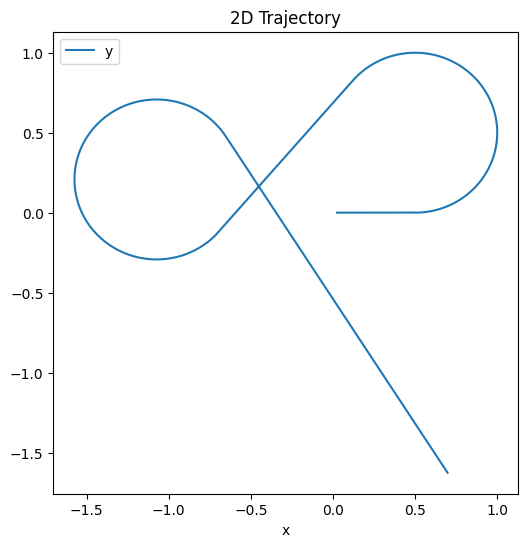

In [14]:
Ydf = pd.DataFrame(np.vstack(turtlebot_block.Y),columns=["x", "y", "theta"])
Ydf.plot(x="x", y="y", kind="line", figsize=(6, 6), title="2D Trajectory")

In [12]:
import numpy as np
from turtlesim.msg import Pose
from std_msgs.msg import Float64

# converter: turtlesim Pose -> ndarray [x, y, theta, v_lin, v_ang]
def pose_ros2py(msg: Pose) -> np.ndarray:
    return np.array([msg.x, msg.y, msg.theta, msg.linear_velocity, msg.angular_velocity], dtype=float)

# converter: ndarray [KE] -> Float64
def ke_py2ros(arr: np.ndarray) -> Float64:
    val = float(np.asarray(arr, dtype=float).ravel()[0])
    return Float64(data=val)

def kinetic_energy_system(tk: float, inputs: dict) -> dict:
    """
    inputs["/turtle1/pose"] = [x, y, theta, v_lin, v_ang]
    returns {"/kinetic_energy": [KE]}
    """
    if "/turtle1/pose" not in inputs:
        return {}
    _, _, _, v_lin, _ = inputs["/turtle1/pose"].ravel().tolist()
    m = 1.0  # assume mass = 1
    KE = 0.5 * m * (v_lin ** 2)
    return {"/kinetic_energy": np.array([KE], dtype=float)}


In [13]:
from pykal_core.blocks import ROSBlock
block = ROSBlock(
    node_name="turtlesim_ke_block",
    system_wrapper=kinetic_energy_system,
    subscribes_to=["/turtle1/pose"],
    publishes_to=["/kinetic_energy"],
    sub_msg_types={"/turtle1/pose": Pose},
    pub_msg_types={"/kinetic_energy": Float64},
    ros2py_dict={"/turtle1/pose": pose_ros2py},
    py2ros_dict={"/kinetic_energy": ke_py2ros},
    rate_hz=10.0,
)
# block.start()
# print("Node running: /turtle1/pose -> /kinetic_energy")


[INFO] [1758249064.086577541] [turtlesim_ke_block]: [turtlesim_ke_block] subs=['/turtle1/pose'], pubs=['/kinetic_energy'], rate=10.0 Hz


In [14]:
import math
import numpy as np
import time

from turtlesim.msg import Pose
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Quaternion, TransformStamped
import tf2_ros

# If your ROSBlock is already defined in the notebook, use it directly.
# Otherwise: from pykal_core.blocks import ROSBlock

def wrap_pi(a):
    """Wrap angle to (-pi, pi]."""
    return (a + math.pi) % (2*math.pi) - math.pi

def yaw_to_quat(yaw: float) -> Quaternion:
    q = Quaternion()
    q.x = 0.0
    q.y = 0.0
    q.z = math.sin(0.5 * yaw)
    q.w = math.cos(0.5 * yaw)
    return q

def pose_ros2py(msg: Pose) -> np.ndarray:
    """turtlesim/Pose -> [x, y, yaw, v_lin, v_ang]"""
    return np.array([msg.x, msg.y, msg.theta, msg.linear_velocity, msg.angular_velocity], dtype=float)

In [15]:
# --- Tunable "realistic" noise parameters ---
alpha_v = 0.02   # linear scale error (e.g., +2%)
alpha_w = 0.01   # angular scale error (e.g., +1%)

sigma_v = 0.05   # m/s white noise on linear velocity
sigma_w = 0.04   # rad/s white noise on angular velocity

sigma_bv = 0.01  # m/s/sqrt(s) bias RW for linear velocity
sigma_bw = 0.01  # rad/s/sqrt(s) bias RW for angular velocity

# Covariances to publish (6x6 diag -> flattened) for [x y z roll pitch yaw]
pos_var  = 0.02**2
yaw_var  = 0.05**2
P_pose = np.diag([pos_var, pos_var, 1e6, 1e6, 1e6, yaw_var])  # z, roll, pitch large/unknown

# Twist covariance for [vx vy vz wx wy wz]
vx_var = sigma_v**2
wz_var = sigma_w**2
P_twist = np.diag([vx_var, 1e6, 1e6, 1e6, 1e6, wz_var])

def odom_py2ros(arr: np.ndarray) -> Odometry:
    """
    [x_odom, y_odom, yaw_odom, vx_hat, vy_hat, wz_hat] -> nav_msgs/Odometry
    with simple, static covariances.
    """
    arr = np.asarray(arr, dtype=float).ravel()
    x, y, yaw, vx, vy, wz = (arr.tolist() + [0,0,0,0,0,0])[:6]

    msg = Odometry()
    msg.header.frame_id = "odom"
    msg.child_frame_id = "base_link"

    msg.pose.pose.position.x = x
    msg.pose.pose.position.y = y
    msg.pose.pose.position.z = 0.0
    msg.pose.pose.orientation = yaw_to_quat(yaw)
    msg.pose.covariance = P_pose.reshape(-1).tolist()

    msg.twist.twist.linear.x = vx
    msg.twist.twist.linear.y = vy
    msg.twist.twist.angular.z = wz
    msg.twist.covariance = P_twist.reshape(-1).tolist()
    return msg

# --- Stateful odometry "estimator" (integrates noisy velocities) ---
state = {
    "t_prev": None,
    "x": 0.0, "y": 0.0, "yaw": 0.0,  # odom estimate in odom frame
    "bv": 0.0, "bw": 0.0,            # biases for v and w (random walk)
}

def noisy_odom_system(block,  # we pass the ROSBlock to access its tf broadcaster
                      tk: float,
                      inputs: dict) -> dict:
    """
    inputs['/turtle1/pose'] = [x_true, y_true, yaw_true, v_true, w_true]
    Internally:
      - corrupt v_true, w_true with scale, white noise, and bias RW
      - integrate to update (x, y, yaw)
      - publish /tf (odom -> base_link) using the *estimated* pose
      - output an array for /odom -> converted by odom_py2ros
    """
    if "/turtle1/pose" not in inputs:
        return {}

    x_true, y_true, yaw_true, v_true, w_true = inputs["/turtle1/pose"].ravel().tolist()

    # Time step
    if state["t_prev"] is None:
        state["t_prev"] = tk
        return {}
    dt = max(1e-3, tk - state["t_prev"])
    state["t_prev"] = tk

    # Bias random walk
    state["bv"] += np.random.normal(0.0, sigma_bv * np.sqrt(dt))
    state["bw"] += np.random.normal(0.0, sigma_bw * np.sqrt(dt))

    # Measured (noisy) velocities
    v_hat = (1.0 + alpha_v) * v_true + state["bv"] + np.random.normal(0.0, sigma_v)
    w_hat = (1.0 + alpha_w) * w_true + state["bw"] + np.random.normal(0.0, sigma_w)

    # Integrate simple unicycle using noisy measurements
    yaw_mid = state["yaw"] + 0.5 * w_hat * dt
    state["x"]   += v_hat * math.cos(yaw_mid) * dt
    state["y"]   += v_hat * math.sin(yaw_mid) * dt
    state["yaw"]  = wrap_pi(state["yaw"] + w_hat * dt)

    # Publish TF (odom -> base_link) for the *estimated* pose
    if hasattr(block, "tf_broadcaster"):
        ts = TransformStamped()
        now = block.get_clock().now().to_msg()
        ts.header.stamp = now
        ts.header.frame_id = "odom"
        ts.child_frame_id = "base_link"
        ts.transform.translation.x = state["x"]
        ts.transform.translation.y = state["y"]
        ts.transform.translation.z = 0.0
        q = yaw_to_quat(state["yaw"])
        ts.transform.rotation = q
        try:
            block.tf_broadcaster.sendTransform(ts)
        except Exception as e:
            block.get_logger().error(f"TF send failed: {e}")

    # Output for /odom topic: include our noisy velocities
    out = np.array([state["x"], state["y"], state["yaw"], v_hat, 0.0, w_hat], dtype=float)
    return {"/odom": out}


In [16]:
from pykal_core.blocks import ROSBlock

# Build the ROSBlock
bridge = ROSBlock(
    node_name="turtlesim_noisy_odom_with_tf",
    system_wrapper=None,  # we'll set it after we attach tf broadcaster
    subscribes_to=["/turtle1/pose"],
    publishes_to=["/odom"],
    sub_msg_types={"/turtle1/pose": Pose},
    pub_msg_types={"/odom": Odometry},
    ros2py_dict={"/turtle1/pose": pose_ros2py},
    py2ros_dict={"/odom": odom_py2ros},
    rate_hz=30.0,  # reasonably fast
)

# Attach TF broadcaster and system function that can use it
bridge.tf_broadcaster = tf2_ros.TransformBroadcaster(bridge)

# Wrap system so it can see `bridge`
bridge._system_wrapper = lambda tk, inputs: noisy_odom_system(bridge, tk, inputs)

# Start
# bridge.start()

[INFO] [1758249064.273701422] [turtlesim_noisy_odom_with_tf]: [turtlesim_noisy_odom_with_tf] subs=['/turtle1/pose'], pubs=['/odom'], rate=30.0 Hz


In [17]:
import math
import numpy as np
from numpy.typing import NDArray

# yaw <-> quat helpers
def yaw_from_quat(q) -> float:
    # q has fields x,y,z,w (geometry_msgs/Quaternion)
    siny_cosp = 2.0 * (q.w * q.z + q.x * q.y)
    cosy_cosp = 1.0 - 2.0 * (q.y*q.y + q.z*q.z)
    return math.atan2(siny_cosp, cosy_cosp)

# pack/unpack [x ; vec(P)]
def _infer_nx_from_len(L: int) -> int:
    n = int((np.sqrt(1 + 4*L) - 1) // 2)
    if n + n*n != L:
        raise ValueError(f"bad length {L} for [x;vec(P)]")
    return n

def _unpack_xP(xP_vec: NDArray):
    v = np.asarray(xP_vec, dtype=float).reshape(-1, 1)
    nx = _infer_nx_from_len(int(v.size))
    x = v[:nx].reshape(nx, 1)
    P = v[nx:].reshape(nx, nx)
    return x, P

def _pack_xP(x: NDArray, P: NDArray) -> NDArray:
    nx = int(x.size)
    return np.vstack([x.reshape(nx,1), P.reshape(nx*nx,1)])

# unicycle discrete model (dt)
def f_unicycle_dt(x: NDArray, u: NDArray, dt: float) -> NDArray:
    th = float(x[2]); v, w = float(u[0]), float(u[1])
    dx = np.array([[v*np.cos(th)], [v*np.sin(th)], [w]])
    return x + dt*dx

def F_jac(x: NDArray, u: NDArray, dt: float) -> NDArray:
    th = float(x[2]); v = float(u[0])
    return np.array([[1,0,-dt*v*np.sin(th)],
                     [0,1, dt*v*np.cos(th)],
                     [0,0, 1]], dtype=float)

def H_jac(nx: int) -> NDArray:
    return np.eye(nx)

# simple Q/R (tune to your setup)
def Q_proc(dt: float, sigma_v=0.05, sigma_w=0.04) -> NDArray:
    return np.diag([(dt*sigma_v)**2, (dt*sigma_v)**2, (dt*sigma_w)**2])

def R_meas(sigma_pos=0.02, sigma_yaw=0.05) -> NDArray:
    return np.diag([sigma_pos**2, sigma_pos**2, sigma_yaw**2])

# EKF "dynamics": one predict (+update if z provided); state = [x ; vec(P)]
def f_ekf(xP_vec: NDArray, t=None, *, dt=0.1, u=None, z=None, Q=None, R=None, arg_dict=None) -> NDArray:
    # allow pulling u/z from arg_dict (we’ll feed odom there)
    if arg_dict:
        if z is None and "z" in arg_dict:
            z = np.asarray(arg_dict["z"], dtype=float).reshape(-1,1)
        if u is None and "u" in arg_dict:
            u = np.asarray(arg_dict["u"], dtype=float).reshape(2,1)
    if u is None: u = np.zeros((2,1))
    x, P = _unpack_xP(xP_vec); nx = int(x.size)

    # predict
    x_pred = f_unicycle_dt(x, u, dt)
    Fk = F_jac(x, u, dt)
    Qk = Q if Q is not None else Q_proc(dt)
    P_pred = Fk @ P @ Fk.T + Qk

    # update (identity measurement) if z present
    if z is not None:
        z = np.asarray(z, dtype=float).reshape(nx,1)
        Hk = H_jac(nx); Rk = R if R is not None else R_meas()
        y = z - x_pred
        S = Hk @ P_pred @ Hk.T + Rk
        K = P_pred @ Hk.T @ np.linalg.inv(S)
        x_upd = x_pred + K @ y
        I = np.eye(nx)
        P_upd = (I - K @ Hk) @ P_pred @ (I - K @ Hk).T + K @ Rk @ K.T
        return _pack_xP(x_upd, P_upd)
    return _pack_xP(x_pred, P_pred)

# EKF output is the estimated state x only
def h_ekf(xP_vec: NDArray, t=None) -> NDArray:
    x, _ = _unpack_xP(xP_vec); return x


In [18]:
from nav_msgs.msg import Odometry
from std_msgs.msg import Float64MultiArray

# assume your DSBlock + Simulation are available in scope
# from pykal_core.blocks import DSBlock, ROSBlock  # ROSBlock is your class
# from pykal_core.sim import Simulation            # whatever module holds Simulation

ekf_block = DSBlock(f=f_ekf, h=h_ekf, sys_type="dti")

# /odom -> ndarray [x, y, yaw, vx, vy, wz]
def odom_ros2py(msg: Odometry) -> NDArray:
    p = msg.pose.pose.position
    q = msg.pose.pose.orientation
    yaw = yaw_from_quat(q)
    vx = msg.twist.twist.linear.x
    vy = msg.twist.twist.linear.y
    wz = msg.twist.twist.angular.z
    return np.array([p.x, p.y, yaw, vx, vy, wz], dtype=float)

# ndarray -> Float64MultiArray
def xhat_py2ros(arr: NDArray) -> Float64MultiArray:
    a = np.asarray(arr, dtype=float).ravel()
    return Float64MultiArray(data=a.tolist())

def Phat_py2ros(P: NDArray) -> Float64MultiArray:
    a = np.asarray(P, dtype=float).ravel()  # row-major 3x3 -> length 9
    return Float64MultiArray(data=a.tolist())

# Initialize EKF wrapper that ROSBlock will call
def ekf_ros_wrapper_initialize(x0: NDArray, P0: NDArray, *, dt: float = 0.1):
    x0 = np.asarray(x0, dtype=float).reshape(3,1)
    P0 = np.asarray(P0, dtype=float).reshape(3,3)
    xP0 = _pack_xP(x0, P0)
    ekf_block.X.append(xP0)  # store packed [x;vec(P)]

    def system_wrapper(tk, inputs: dict):
        if "/odom" not in inputs:
            return {}  # wait for first measurement
        od = np.asarray(inputs["/odom"], dtype=float).ravel()
        # measurement z = [x,y,yaw], control u = [vx, wz] from odom twist
        z = od[:3].reshape(1,3)
        u = np.array([od[3], od[5]], dtype=float).reshape(1,2)

        xP_prev = ekf_block.X[-1]
        # advance EKF one step via your Simulation helper
        xP_next, x_hat = Simulation.of_dynamical_system_block(
            block=ekf_block,
            x0=xP_prev,
            tk=tk,
            dt=dt,
            arg_dict={"u": u, "z": z},   # f_ekf will read these
        )
        ekf_block.X.append(xP_next)
        # unpack P for publishing too
        _, P_hat = _unpack_xP(xP_next)
        return {
            "/x_hat": x_hat,     # shape (3,1)
            "/P_hat": P_hat,     # shape (3,3), we’ll flatten in py2ros
        }
    return system_wrapper


In [19]:
import rclpy
from pykal_core.blocks import ROSBlock  # your class

# Ensure rclpy is initialized before constructing Node (if your ROSBlock doesn't auto-init)
if not rclpy.ok():
    rclpy.init(args=None)

# Initial belief
x0 = np.array([0.0, 0.0, 0.0])
P0 = np.diag([0.5**2, 0.5**2, (15*np.pi/180)**2])  # fairly uncertain

ekf_system_fn = ekf_ros_wrapper_initialize(x0, P0, dt=0.1)

ekf_node = ROSBlock(
    node_name="ekf_from_odom",
    system_wrapper=ekf_system_fn,
    subscribes_to=["/odom"],
    publishes_to=["/x_hat", "/P_hat"],
    sub_msg_types={"/odom": Odometry},
    pub_msg_types={"/x_hat": Float64MultiArray, "/P_hat": Float64MultiArray},
    ros2py_dict={"/odom": odom_ros2py},
    py2ros_dict={"/x_hat": xhat_py2ros, "/P_hat": Phat_py2ros},
    rate_hz=10.0,
)
# ekf_node.start()
# print("EKF node up: /odom → {/x_hat, /P_hat}")


[INFO] [1758249064.309630320] [ekf_from_odom]: [ekf_from_odom] subs=['/odom'], pubs=['/x_hat', '/P_hat'], rate=10.0 Hz


[ERROR] [1758249064.409371460] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249064.509519136] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate


[ROSBlock] started node='turtlesim_noisy_odom_with_tf' pub=['/odom'] sub=['/turtle1/pose'] @ 30.0 Hz
[ROSBlock] started node='ekf_from_odom' pub=['/x_hat', '/P_hat'] sub=['/odom'] @ 10.0 Hz
✅ Nodes started. In a terminal run:
  ros2 run turtlesim turtlesim_node
  ros2 run turtlesim turtle_teleop_key
📈 Collecting 20s of data… drive the turtle!


[ERROR] [1758249064.609450595] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249064.709142823] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249064.809103968] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249064.909069511] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249065.009319891] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249065.109110695] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249065.208959999] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249065.309357877] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249065.409744113] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249065

ValueError: x and y must have same first dimension, but have shapes (1250,) and (1251,)

[ERROR] [1758249085.168065411] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249085.212240629] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate


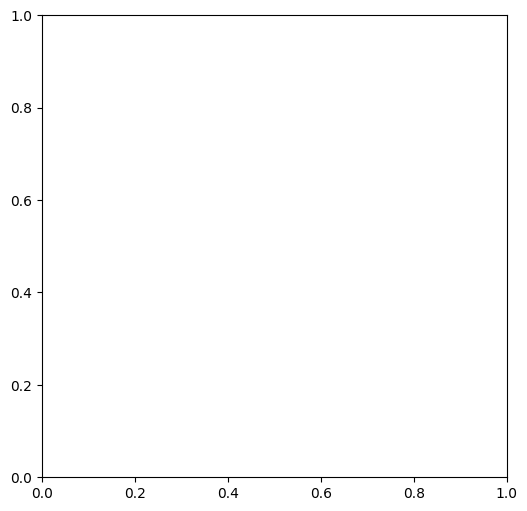

[ERROR] [1758249085.309099605] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249085.409281592] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249085.509169345] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249085.609994583] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249085.709046461] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249085.809588837] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249085.911631179] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249086.011127614] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249086.109613446] [ekf_from_odom]: system_wrapper error: need at least one array to concatenate
[ERROR] [1758249086

In [ ]:
from matplotlib import pyplot as plt
# ---------- Start both nodes ----------
bridge.start()
ekf_node.start()
print("✅ Nodes started. In a terminal run:\n  ros2 run turtlesim turtlesim_node\n  ros2 run turtlesim turtle_teleop_key")

# ---------- Lightweight subscribers for logging (attach to ekf_node) ----------
gt = {"t": [], "x": [], "y": [], "yaw": []}
est = {"t": [], "x": [], "y": [], "yaw": []}

def _pose_cb(msg: Pose):
    gt["t"].append(time.time())
    gt["x"].append(msg.x); gt["y"].append(msg.y); gt["yaw"].append(msg.theta)

def _xhat_cb(msg: Float64MultiArray):
    arr = np.asarray(msg.data, dtype=float).ravel()
    if arr.size >= 3:
        est["t"].append(time.time())
        est["x"].append(arr[0]); est["y"].append(arr[1]); est["yaw"].append(arr[2])

# attach subscribers
ekf_node.create_subscription(Pose, "/turtle1/pose", _pose_cb, 10)
ekf_node.create_subscription(Float64MultiArray, "/x_hat", _xhat_cb, 10)

# ---------- Collect for ~20s while you drive ----------
collect_sec = 20
print(f"📈 Collecting {collect_sec}s of data… drive the turtle!")
t0 = time.time()
while time.time() - t0 < collect_sec:
    time.sleep(0.05)

# ---------- Plot ----------
plt.figure(figsize=(6,6))
if gt["x"]:
    plt.plot(gt["x"], gt["y"], label="Ground truth (turtlesim pose)")
if est["x"]:
    plt.plot(est["x"], est["y"], linestyle="--", label="EKF estimate (/x_hat)")
plt.gca().set_aspect("equal", adjustable="box")
plt.xlabel("x [m]"); plt.ylabel("y [m]")
plt.title("Trajectory: ground truth vs. EKF")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(7,3))
if gt["t"] and est["t"]:
    t_gt0 = gt["t"][0]; t_est0 = est["t"][0]
    t_gt = np.array(gt["t"]) - t_gt0
    t_est = np.array(est["t"]) - t_est0
    plt.plot(t_gt, gt["yaw"], label="yaw (gt)")
    plt.plot(t_est, est["yaw"], label="yaw (EKF)", linestyle="--")
    plt.xlabel("time [s]"); plt.ylabel("yaw [rad]")
    plt.title("Heading vs. time")
    plt.grid(True); plt.legend()
plt.show()

# (leave nodes running; stop when you’re done)
# bridge.stop(); ekf_node.stop()

In [21]:
bridge.stop(); ekf_node.stop()

[ROSBlock] stopped.
[ROSBlock] stopped.
